In [1]:
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import load_model
import os
import rasterio
from rasterio.plot import show
from matplotlib.colors import LogNorm


In [2]:
import os
import cv2
import tifffile
import numpy as np

size = 256

def split_image_into_tiles(image_path, mask_path, tile_size):
    img = tifffile.imread(image_path)
    mask = tifffile.imread(mask_path)

    mask = mask[:, :, 0] if len(mask.shape) == 3 else mask
    print(f"Original Image Dimensions: {img.shape}")
    tiles_img = []
    tiles_mask = []

    for x in range(0, img.shape[1], tile_size):
        for y in range(0, img.shape[0], tile_size):
            tile_img = img[y:y+tile_size, x:x+tile_size, :] if len(img.shape) == 3 else img[y:y+tile_size, x:x+tile_size]
            tile_mask = mask[y:y+tile_size, x:x+tile_size]

            # Resize to the desired size
            tile_img = cv2.resize(tile_img, (size, size))
            tile_mask = cv2.resize(tile_mask, (size, size))
            tile_mask = (tile_mask > 0).astype(np.uint8)

            tiles_img.append(tile_img)
            tiles_mask.append(tile_mask)

    # Calculate the number of tiles needed to form a perfect square
    num_tiles = len(tiles_img)
    perfect_square_size = int(np.ceil(np.sqrt(num_tiles)))
    total_tiles_needed = perfect_square_size**2
    num_tiles_to_add = total_tiles_needed - num_tiles

    # Pad the list of tiles with zeros
    for _ in range(num_tiles_to_add):
        tiles_img.append(np.zeros((size, size, img.shape[2]), dtype=np.uint8))
        tiles_mask.append(np.zeros((size, size), dtype=np.uint8))

    tiles_img = np.array(tiles_img)
    tiles_mask = np.array(tiles_mask)

    return tiles_img, tiles_mask

# Function to load data
def load_data(image_dir, mask_dir, tile_size):
    images = []
    masks = []

    # Sort filenames to ensure consistency
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for image_filename in image_filenames:
        if image_filename.endswith(".TIF"):
            mask_filename = image_filename.replace(".TIF", "_mask.TIF")

            if mask_filename in mask_filenames:
                image_path = os.path.join(image_dir, image_filename)
                mask_path = os.path.join(mask_dir, mask_filename)

                print(f"Processing Image: {image_filename}, Mask: {mask_filename}")

                img, mask = split_image_into_tiles(image_path, mask_path, tile_size)

                images.extend(img)
                masks.extend(mask)

    return np.array(images), np.array(masks)

# Define  paths
image_dir = "datasets/images"
mask_dir = "datasets/masks"

# Tile size
tile_size = size

# Load data
tiles_img, tiles_mask = load_data(image_dir, mask_dir, tile_size)

# Display the number of tiles produced
print(f"Number of tile images: {tiles_img.shape[0]}")
print(f"Number of tile masks: {tiles_mask.shape[0]}")


Processing Image: 2.TIF, Mask: 2_mask.TIF
Original Image Dimensions: (7151, 7941, 3)
Number of tile images: 900
Number of tile masks: 900


In [3]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tiles_img, tiles_mask, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Reshape masks
y_train = y_train.reshape(y_train.shape + (1,))
y_val = y_val.reshape(y_val.shape + (1,))
y_test = y_test.reshape(y_test.shape + (1,))

# Create an instance of ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Create empty lists to store augmented images and masks
augmented_images = []
augmented_masks = []

# Choose the number of augmentations per original image
num_augmentations = 6

# Iterate over original images and masks
for i in range(X_train.shape[0]):
    image = X_train[i]
    mask = y_train[i]

    # Reshape mask to (height, width, 1) if it's not already
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)

    # Expand dimensions of both image and mask to (1, height, width, channels)
    image = np.expand_dims(image, axis=0)
    mask = np.expand_dims(mask, axis=0)

    # Generate augmentations
    aug_iter = datagen.flow(image, mask, batch_size=1)
    for _ in range(num_augmentations):
        augmented_image, augmented_mask = next(aug_iter)

        # Append augmented image and mask to the lists
        augmented_images.append(augmented_image[0])
        augmented_masks.append(augmented_mask[0])

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Append augmented images/masks with original images/masks
X_train_augmented = np.concatenate([X_train, augmented_images])
y_train_augmented = np.concatenate([y_train, augmented_masks])


# Print the number of original and augmented images
print(f"Number of original images: {X_train.shape[0]}")
print(f"Number of augmented images: {augmented_images.shape[0]}")
print(f"Total number of images in the augmented dataset: {X_train_augmented.shape[0]}")

# Print the number of original and augmented mask images
print(f"Number of original mask images: {y_train.shape[0]}")
print(f"Number of augmented mask images: {augmented_masks.shape[0]}")
print(f"Total number of mask images in the augmented dataset: {y_train_augmented.shape[0]}")



Number of original images: 648
Number of augmented images: 3888
Total number of images in the augmented dataset: 4536
Number of original mask images: 648
Number of augmented mask images: 3888
Total number of mask images in the augmented dataset: 4536





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['dropout[0][0]']             
                                                                                           

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.7752
Epoch 2: val_loss improved from 0.69926 to 0.66625, saving model to best_weight_unet_301223.h5
142/142 [==============================] - 300s 2s/step - loss: 0.6952 - accuracy: 0.7752 - val_loss: 0.6662 - val_accuracy: 0.8837 - lr: 1.0000e-04
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.8522
Epoch 3: val_loss improved from 0.66625 to 0.45053, saving model to best_weight_unet_301223.h5
142/142 [==============================] - 298s 2s/step - loss: 0.6280 - accuracy: 0.8522 - val_loss: 0.4505 - val_accuracy: 0.8837 - lr: 1.0000e-04
Epoch 4/100
142/142 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.8532
Epoch 4: val_loss improved from 0.45053 to 0.43287, saving model to best_weight_unet_301223.h5
142/142 [==============================] - 297s 2s/step - loss: 0.4764 - accuracy: 0.8532 - val_loss: 0.4329 - val_accuracy: 0.8837 - lr: 

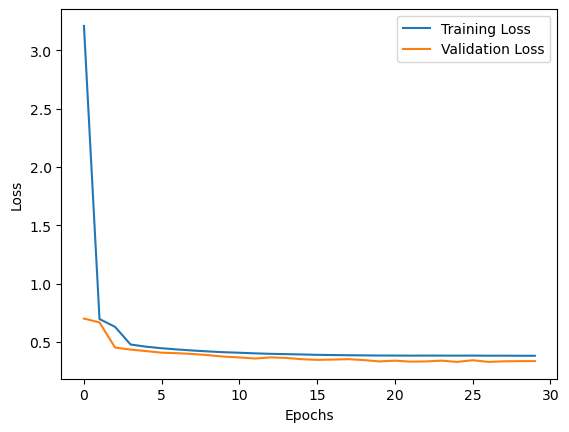

In [4]:
size = 256
# Define U-Net model
def unet_model(input_size=(size, size, 3)):
    inputs = Input(input_size)

    # Encoder
    x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x_temp = Dropout(0.25)(x_temp)
    x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = MaxPooling2D((2, 2))(x_skip1)
    x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = Dropout(0.25)(x_temp)
    x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = MaxPooling2D((2, 2))(x_skip2)
    x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = Dropout(0.25)(x_temp)
    x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = MaxPooling2D((2, 2))(x_skip3)
    x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = Dropout(0.5)(x_temp)
    x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

    # Decoder
    x_temp = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = Dropout(0.5)(x_temp)
    x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
    x_temp = Concatenate()([x_temp, x_skip3])
    x_temp = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = Dropout(0.5)(x_temp)
    x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
    x_temp = Concatenate()([x_temp, x_skip2])
    x_temp = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = Dropout(0.5)(x_temp)
    x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
    x_temp = Concatenate()([x_temp, x_skip1])
    x_temp = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x_temp)
    x_temp = Dropout(0.5)(x_temp)
    x_temp = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x_temp)

    # Use 1 by 1 Convolution to get desired output bands
    x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
    x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
    x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

    # Use sigmoid activation here because output values are either 0 or 1

    model = Model(inputs=inputs, outputs=x_out)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model

# Create U-Net model
model = unet_model(input_size=(size, size, 3))

# Learning rate schedule
def lr_schedule(epoch):
    initial_learning_rate = 0.0001
    decay = 0.9
    if epoch % 10 == 0 and epoch:
        return initial_learning_rate * decay
    return initial_learning_rate

# Use LearningRateScheduler callback to adjust learning rate dynamically
#lr_scheduler = LearningRateScheduler(lr_schedule)

# Use LearningRateScheduler callback to adjust learning rate dynamically
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# callback function to stop overfitting the model
checkpointer = ModelCheckpoint("best_weight_unet_301223.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
]


# Train the model on the augmented training set
#history = model.fit(X_train_augmented, y_train_augmented, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

# Train the model on the augmented training set with callbacks
history = model.fit(X_train_augmented, y_train_augmented, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=1,
                    validation_data=(X_val, y_val), 
                    callbacks=[lr_scheduler] + callbacks)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Save the model
model.save('forest_detection_model_unet_augmented_301223.h5')

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


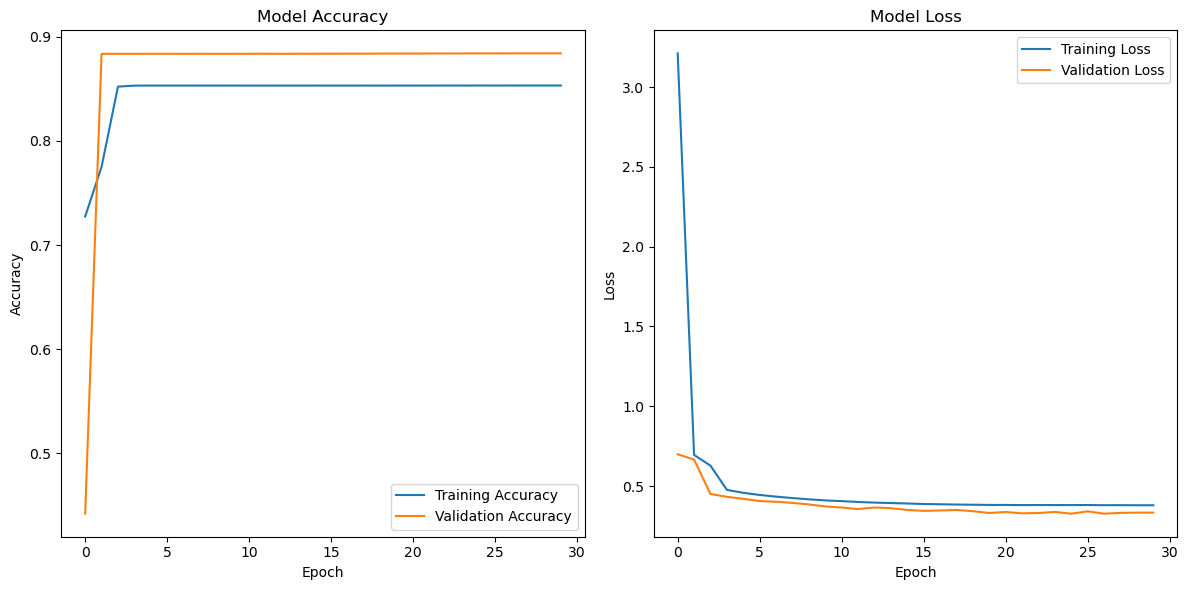

In [5]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

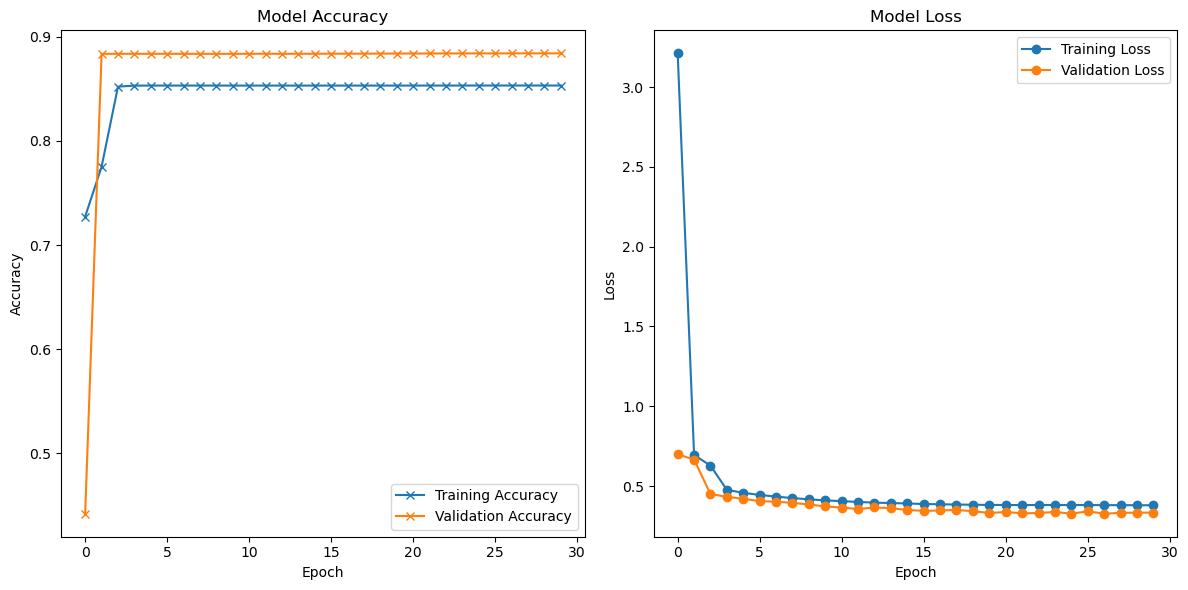

In [6]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", marker='x')
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='x')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", marker='o')
plt.plot(history.history["val_loss"], label="Validation Loss", marker='o')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import re
import tifffile
from keras.models import load_model
from keras.preprocessing.image import img_to_array

size = 256
# Load the pre-trained U-Net model
model = load_model('best_weight_unet_301223.h5')

def scaleStd(x):
    return (x - (np.nanmean(x) - np.nanstd(x) * 2)) / ((np.nanmean(x) + np.nanstd(x) * 2) - (np.nanmean(x) - np.nanstd(x) * 2))

def preprocess_input(image):
    # Assuming pixel values are in the range [0, 255]
    image = image / 255.0
    return image

def calculate_deforestation_percentage(image_paths, tile_size=size):
    num_years = len(image_paths)

    deforestation_percentages = []
    forest_percentages = []

    for i in range(num_years - 1):
        j = i + 1

        # Preprocess the images and split into tiles
        images_i = [preprocess_image(image_path, tile_size) for image_path in image_paths[i:i+2]]

        # Flatten the list of tiles
        tiles_i = [tile for tiles_per_image in images_i for tile in tiles_per_image]

        # Predict using the trained model for all tiles
        predictions_i = [model.predict(np.expand_dims(tile, axis=0)) for tile in tiles_i]

        # Calculate the percentage of deforestation for each tile
        deforestation_percentages_i = []
        for k in range(0, len(predictions_i), 2):
            # Calculate the sum of predictions for each pair of tiles
            sum_predictions_i = np.sum(predictions_i[k], axis=-1)
            sum_predictions_j = np.sum(predictions_i[k + 1], axis=-1)

            # Calculate the percentage of deforestation
            non_zero_mask = (sum_predictions_i + sum_predictions_j) != 0
            deforestation_percentage = np.zeros_like(sum_predictions_i)
            deforestation_percentage[non_zero_mask] = (
                np.abs(sum_predictions_j[non_zero_mask] - sum_predictions_i[non_zero_mask]) /
                (sum_predictions_i[non_zero_mask] + sum_predictions_j[non_zero_mask])
            ) * 100

            deforestation_percentages_i.append(np.nanmean(deforestation_percentage))

        # Calculate the overall percentage for this pair of years
        deforestation_percentages.append(np.nanmean(deforestation_percentages_i))

        # Calculate the percentage of remaining forest
        forest_percentage_i = 100 - np.nanmean(deforestation_percentages_i)
        forest_percentages.append(forest_percentage_i)

    return deforestation_percentages, forest_percentages

def visualize_deforestation(image_paths):
    num_images = len(image_paths)

    deforestation_percentages, forest_percentages = calculate_deforestation_percentage(image_paths)

    for i, image_path in enumerate(image_paths):
        # Load the original image using rasterio
        with rasterio.open(image_path) as src:
            r = src.read(3, masked=True)
            g = src.read(2, masked=True)
            b = src.read(1, masked=True)

        rStd = scaleStd(r)
        gStd = scaleStd(g)
        bStd = scaleStd(b)

        rgbStd = np.dstack((rStd, gStd, bStd)).copy()  # Make a copy
        # Commenting out the line that displays the image
        # axes[i].imshow(np.asarray(rgbStd, dtype=np.float32))  # Ensure the array is writable
        # axes[i].set_title(f"Original Image - {os.path.basename(image_path)}")

        # Print deforestation and forest percentages for each image
        if i > 0:
            year1 = extract_year_from_filename(os.path.basename(image_paths[i - 1]))
            year2 = extract_year_from_filename(os.path.basename(image_path))
            deforestation_text = f"Non-Forest Percentage - {year1} to {year2}: {deforestation_percentages[i - 1]:.2f}%"
            forest_text = f"Remaining Forest Percentage - {year1} to {year2}: {forest_percentages[i - 1]:.2f}%"
            print(deforestation_text)
            print(forest_text)


def extract_year_from_filename(filename):
    # Extract the last 4 digits from the filename
    match = re.search(r'\d{4}', filename)
    if match:
        return int(match.group())
    else:
        return None

def preprocess_image(image_path, tile_size=size):
    # Load and preprocess the image
    img = tifffile.imread(image_path)
    img_height, img_width, _ = img.shape

    # Split the image into tiles
    tiles = []
    for y in range(0, img_height, tile_size):
        for x in range(0, img_width, tile_size):
            tile = img[y:y+tile_size, x:x+tile_size, :]
            tiles.append(tile)

    # Pad tiles with zeros to the maximum width and height
    max_width = max(tile.shape[1] for tile in tiles)
    max_height = max(tile.shape[0] for tile in tiles)
    padded_tiles = [np.pad(tile, ((0, max_height - tile.shape[0]), (0, max_width - tile.shape[1]), (0, 0)), 'constant') for tile in tiles]

    # Preprocess each tile
    preprocessed_tiles = [preprocess_input(img_to_array(tile)) for tile in padded_tiles]

    return preprocessed_tiles

# Provide the directory containing satellite images for different years
image_directory = "testimage/modhu"
image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith(".TIF")]

# Visualize deforestation on the original images without showing the map
visualize_deforestation(image_paths)

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Load the saved model
loaded_model = tf.keras.models.load_model('best_weight_unet_301223.h5')

# Predict on the test set
y_pred = loaded_model.predict(X_test)

# Threshold predictions to obtain binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Flatten the arrays for computing metrics
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


6/6 [==============================] - 2s 351ms/step
Accuracy: 0.8965
F1 Score: 0.8809
Precision: 0.9857
Recall: 0.7963


In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('best_weight_unet_301223.h5')

# Predictions on the test set
y_pred = loaded_model.predict(X_test)

# Threshold the predictions to get binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Flatten the arrays for metrics calculation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate and print accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print F1 score
f1 = f1_score(y_test_flat, y_pred_flat)
print(f'F1 Score: {f1:.4f}')

# Calculate and print precision
precision = precision_score(y_test_flat, y_pred_flat)
print(f'Precision: {precision:.4f}')

# Calculate and print recall
recall = recall_score(y_test_flat, y_pred_flat)
print(f'Recall: {recall:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate mean intersection over union (mIoU)
intersection = np.sum(np.logical_and(y_test_flat, y_pred_flat))
union = np.sum(np.logical_or(y_test_flat, y_pred_flat))
miou = intersection / union
print(f'Mean Intersection over Union (mIoU): {miou:.4f}')


6/6 [==============================] - 2s 357ms/step
Accuracy: 0.8965
F1 Score: 0.8809
Precision: 0.9857
Recall: 0.7963
Confusion Matrix:
[[6061670   65542]
 [1155093 4514175]]
Mean Intersection over Union (mIoU): 0.7872
